In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os  
from matplotlib.ticker import PercentFormatter
from scipy.optimize import curve_fit


# plot cpu, gpu power pattern for GPGPU apps
def replace_negative_with_average(data, column_name):
    for i in range(1, len(data) - 1):
        if data.at[i, column_name] < 0:
            previous_value = data.at[i - 1, column_name]
            next_value = data.at[i + 1, column_name]
            data.at[i, column_name] = (previous_value + next_value) / 2

def plot_power_CPU_GPU(cpu_filename, gpu_filename, benchmark):
    # Load the CSV files into DataFrames
    cpu_data = pd.read_csv(cpu_filename)
    gpu_data = pd.read_csv(gpu_filename)

    # Replace negative values with the average of the previous and next values
    replace_negative_with_average(cpu_data, 'Package Power (W)')
    replace_negative_with_average(gpu_data, 'GPU 0 Power (W)')

    # Plot the data
    plt.figure(figsize=(4, 3))
    plt.plot(cpu_data['Time (s)'], cpu_data['Package Power (W)'], label='RAPL Package Power', color='blue')
    plt.plot(gpu_data['Time (s)'], gpu_data['GPU 0 Power (W)'], label='GPU Power', color='red')
    plt.xlabel('Time (s)')
    plt.ylabel('Power (W)')
    plt.title(f'Power Consumption ({benchmark})', pad=40)
    # Position the legend outside the plot
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
    plt.grid(True, axis="y", alpha=0.5)
    
    # Make sure the ./fig directory exists, if not, create it
    os.makedirs('./fig', exist_ok=True)
    # Save the figure
    plt.savefig(f'./fig/power_cpu_gpu_{benchmark}.jpg', bbox_inches='tight')
    plt.show()

def plot_power_CPU(cpu_filename, benchmark):
    # Load the CSV file into a DataFrame
    cpu_data = pd.read_csv(cpu_filename)

    # Filter the data to plot every 1 second (assuming data points every 0.1 seconds)
    filtered_cpu_data = cpu_data.iloc[::1]  # Select every 10th row

    # Plot the data
    plt.figure(figsize=(6, 4))
    plt.plot(filtered_cpu_data['Time (s)'], filtered_cpu_data['Package Power (W)'],
             label='RAPL Package Power', color='blue')
    plt.xlabel('Time (s)')
    plt.ylabel('Power (W)')
    plt.title(f'Power Consumption ({benchmark})', pad=40)
    
    # Position the legend outside the plot
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
    plt.grid(True, axis="y", alpha=0.5)
    
    # Save the figure in the ./fig directory
    os.makedirs('./fig', exist_ok=True)
    plt.savefig(f'./fig/power_cpu_{benchmark}.jpg', bbox_inches='tight')
    
    # Display the plot
    plt.show()




# plot the power capping results for GPGPU apps
def plot_power_cap(file_cpu_cap, file_gpu_cap, benchmark,altis):
    def calculate_modified_average(runtimes):
        """Calculate the average runtime after dropping the min and max values."""
        if len(runtimes) > 2:
            return (sum(runtimes) - min(runtimes) - max(runtimes)) / (len(runtimes) - 2)
        return sum(runtimes) / len(runtimes)  # Return average if we can't drop values

    def preprocess_dataframe(file_path):
        """Read and preprocess the data from a CSV file."""
        df = pd.read_csv(file_path)
        # Group by 'CPU Cap (W)' and 'GPU Cap (W)' and aggregate 'Runtime (s)'
        agg_df = df.groupby(['CPU Cap (W)', 'GPU Cap (W)'])['Runtime (s)'].apply(list).reset_index()
        agg_df['Runtime (s)'] = agg_df['Runtime (s)'].apply(calculate_modified_average)
        return agg_df
    
    # Set up subplot environment
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))

    # Process and plot CPU cap data
    df_cpu = preprocess_dataframe(file_cpu_cap)
    # Find base runtime for max CPU Cap
    base_runtime_cpu = df_cpu[df_cpu['CPU Cap (W)'] == df_cpu['CPU Cap (W)'].max()]['Runtime (s)'].iloc[0]
    df_cpu['Performance (%)'] = (base_runtime_cpu / df_cpu['Runtime (s)']) * 100

    # max cpu power cap is 125 for ALTIS, so 250-125 = 125 which is the "decrease start point"
    if altis:
        cap = 125
    else:
        cap = 0
        
    df_cpu['CPU Cap Decrease (W)'] = df_cpu['CPU Cap (W)'].max() + cap - df_cpu['CPU Cap (W)']  # Adjusted for ALTIS benchmark
    axs[0].plot(df_cpu['CPU Cap Decrease (W)'], df_cpu['Performance (%)'], 'o--', linewidth=5, markersize=10)
    axs[0].set_title(f'{benchmark}: fixed max GPU cap', fontsize=20)
    axs[0].set_xlabel('CPU Cap Decrease (W)', fontsize=20)
    axs[0].set_ylabel('Application Performance (%)', fontsize=20)

    # Process and plot GPU cap data
    df_gpu = preprocess_dataframe(file_gpu_cap)
    # Find base runtime for max GPU Cap
    base_runtime_gpu = df_gpu[df_gpu['GPU Cap (W)'] == df_gpu['GPU Cap (W)'].max()]['Runtime (s)'].iloc[0]
    df_gpu['Performance (%)'] = (base_runtime_gpu / df_gpu['Runtime (s)']) * 100
    df_gpu['GPU Cap Decrease (W)'] = df_gpu['GPU Cap (W)'].max() - df_gpu['GPU Cap (W)']
    axs[1].plot(df_gpu['GPU Cap Decrease (W)'], df_gpu['Performance (%)'], 'D--', color='r', linewidth=5, markersize=10)
    axs[1].set_title(f'{benchmark}: fixed max CPU cap', fontsize=20)
    axs[1].set_xlabel('GPU Cap Decrease (W)', fontsize=20)
    axs[1].set_ylabel('Application Performance (%)', fontsize=20)

    for ax in axs:
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()






# plot power cap results for all selected apps on the same plot
def plot_power_cap_all(file_cpu_cap, file_gpu_cap, benchmarks, altis):
    
    def preprocess_dataframe(df):
        # Group by 'CPU Cap (W)' and 'GPU Cap (W)' and calculate the average runtime after dropping the min and max values
        def custom_agg(x):
            if len(x) > 2:
                return (np.sum(x) - np.min(x) - np.max(x)) / (len(x) - 2)
            else:
                return np.mean(x)  # Use average if there are not enough values to remove min and max
        
        processed_df = df.groupby(['CPU Cap (W)', 'GPU Cap (W)'])['Runtime (s)'].agg(custom_agg).reset_index()
        return processed_df
    

    # Set up the figure for subplots
    fig, axs = plt.subplots(1, 2, figsize=(24, 8))
    
    markers = ['D', '+', 'x', 'o', 's', '*', '^']
    colors = ['r', 'g', 'b', 'purple', 'cyan', 'orange', 'pink']
    
    # Process and plot data for each benchmark
    for cpu_file, gpu_file, benchmark, marker, color in zip(file_cpu_cap, file_gpu_cap, benchmarks, markers, colors):
        # CPU cap data
        df_cpu = pd.read_csv(cpu_file)
        df_cpu = preprocess_dataframe(df_cpu)
        base_runtime_cpu = df_cpu[df_cpu['CPU Cap (W)'] == df_cpu['CPU Cap (W)'].max()]['Runtime (s)'].iloc[0]
        df_cpu['Performance (%)'] = 100 * base_runtime_cpu / df_cpu['Runtime (s)']
        
        # max cpu power cap is 125 for ALTIS, so 250-125 = 125 which is the "decrease start point"
        if altis:
            cap = 125
        else:
            cap = 0
        
        df_cpu['CPU Cap Decrease (W)'] = df_cpu['CPU Cap (W)'].max() + cap - df_cpu['CPU Cap (W)']  # Adjust for ALTIS specifics
        axs[0].plot(df_cpu['CPU Cap Decrease (W)'], df_cpu['Performance (%)'], marker=marker, linestyle='-', color=color, linewidth=2, markersize=8, label=f"{benchmark}")
        axs[0].set_xlabel('CPU Power Cap Decrease (W)', fontsize=25)
        
        # GPU cap data
        df_gpu = pd.read_csv(gpu_file)
        df_gpu = preprocess_dataframe(df_gpu)
        base_runtime_gpu = df_gpu[df_gpu['GPU Cap (W)'] == df_gpu['GPU Cap (W)'].max()]['Runtime (s)'].iloc[0]
        df_gpu['Performance (%)'] = 100 * base_runtime_gpu / df_gpu['Runtime (s)']
        df_gpu['GPU Cap Decrease (W)'] = df_gpu['GPU Cap (W)'].max() - df_gpu['GPU Cap (W)']
        axs[1].plot(df_gpu['GPU Cap Decrease (W)'], df_gpu['Performance (%)'], marker=marker, linestyle='-', color=color, linewidth=2, markersize=8, label=f"{benchmark}")
        axs[1].set_xlabel('GPU Power Cap Decrease (W)', fontsize=25)
        
    # Setting labels, titles and other properties for the plots
    for ax, title in zip(axs, ['CPU Cap Decrease (Max GPU Cap)', 'GPU Cap Decrease (Max CPU Cap)']):
        ax.set_ylabel('Application Performance (%)', fontsize=25)
        #ax.set_title(title, fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.legend(fontsize=20)
        ax.tick_params(axis='x', labelsize=25)
        ax.tick_params(axis='y', labelsize=25)
        ax.grid(True)

    plt.tight_layout()
    plt.show()



def calculate_energy(cpu_file, gpu_file):
    # Load GPU data from CSV file
    gpu_data = pd.read_csv(gpu_file)
    # Clean negative values in GPU power data
    gpu_data = clean_data(gpu_data, 'GPU 0 Power (W)')
    
    # Extract the time and power columns for the GPU
    time_gpu = gpu_data['Time (s)'].values
    power_gpu = gpu_data['GPU 0 Power (W)'].values

    # Calculate the total GPU energy using the trapezoidal rule manually
    energy_gpu = 0.0
    for i in range(1, len(time_gpu)):
        dt = time_gpu[i] - time_gpu[i - 1]
        avg_power = (power_gpu[i] + power_gpu[i - 1]) / 2
        energy_gpu += avg_power * dt

    # Load CPU data from CSV file
    cpu_data = pd.read_csv(cpu_file)
    # Clean negative values in CPU power data
    cpu_data = clean_data(cpu_data, 'Package Power (W)')
    
    # Extract the time and power columns for the CPU
    time_cpu = cpu_data['Time (s)'].values
    power_cpu = cpu_data['Package Power (W)'].values

    # Calculate the total CPU energy using the trapezoidal rule manually
    energy_cpu = 0.0
    for i in range(1, len(time_cpu)):
        dt = time_cpu[i] - time_cpu[i - 1]
        avg_power = (power_cpu[i] + power_cpu[i - 1]) / 2
        energy_cpu += avg_power * dt

    # Sum the total energy consumption from both CPU and GPU
    total_energy = energy_cpu + energy_gpu
    print(f'Total Energy Consumption: {round(total_energy, 2)} Joules')


def clean_data(data, column):
    # Iterate through the data to find negative values
    for i in range(1, len(data) - 1):
        if data[column][i] < 0:
            # Replace with the average of the previous and next values
            data.loc[i, column] = (data.loc[i-1, column] + data.loc[i+1, column]) / 2
    return data


def plot_uncore_freq(uncore_file):
    file_path = uncore_file  
    data = pd.read_csv(file_path)
    
    # Plot Core 0 and Core 1 Uncore Frequencies over Time
    plt.figure(figsize=(4, 3))
    
    # Plot Core 0 Uncore Frequency
    plt.plot(data['Time (s)'], data['Core 0 Uncore Frequency (GHz)'], label='Core 0 Uncore Frequency (GHz)')
    
    # Plot Core 1 Uncore Frequency
    plt.plot(data['Time (s)'], data['Core 1 Uncore Frequency (GHz)'], label='Core 1 Uncore Frequency (GHz)')
    
    # Adding labels and title
    plt.xlabel('Time (s)')
    plt.ylabel('Uncore Frequency (GHz)')
    plt.title('Uncore Frequency')
    plt.legend()
    
    # Show the plot
    plt.show()

### Dynamic Uncore freq

In [ ]:
data_dir = "./altis_power_res/dynamic_uncore/"

# altis_benchmarks_0
busspeeddownload_cpu = data_dir + "busspeeddownload_power_cpu.csv"
busspeeddownload_gpu = data_dir + "busspeeddownload_power_gpu.csv"

busspeedreadback_cpu = data_dir + "busspeedreadback_power_cpu.csv"
busspeedreadback_gpu = data_dir + "busspeedreadback_power_gpu.csv"

maxflops_cpu = data_dir + "maxflops_power_cpu.csv"
maxflops_gpu = data_dir + "maxflops_power_gpu.csv"

# altis_benchmarks_1
bfs_cpu = data_dir + "bfs_power_cpu.csv"
bfs_gpu = data_dir + "bfs_power_gpu.csv"

gemm_cpu = data_dir + "gemm_power_cpu.csv"
gemm_gpu = data_dir + "gemm_power_gpu.csv"

gups_cpu = data_dir + "gups_power_cpu.csv"
gups_gpu = data_dir + "gups_power_gpu.csv"

pathfinder_cpu = data_dir + "pathfinder_power_cpu.csv"
pathfinder_gpu = data_dir + "pathfinder_power_gpu.csv"

sort_cpu = data_dir + "sort_power_cpu.csv"
sort_gpu = data_dir + "sort_power_gpu.csv"

# altis_benchmarks_2
cfd_cpu = data_dir + "cfd_power_cpu.csv"
cfd_gpu = data_dir + "cfd_power_gpu.csv"

cfd_double_cpu = data_dir + "cfd_double_power_cpu.csv"
cfd_double_gpu = data_dir + "cfd_double_power_gpu.csv"


fdtd2d_cpu = data_dir + "fdtd2d_power_cpu.csv"
fdtd2d_gpu = data_dir + "fdtd2d_power_gpu.csv"

kmeans_cpu = data_dir + "kmeans_power_cpu.csv"
kmeans_gpu = data_dir + "kmeans_power_gpu.csv"

lavamd_cpu = data_dir + "lavamd_power_cpu.csv"
lavamd_gpu = data_dir + "lavamd_power_gpu.csv"

nw_cpu = data_dir + "nw_power_cpu.csv"
nw_gpu = data_dir + "nw_power_gpu.csv"

particlefilter_float_cpu = data_dir + "particlefilter_float_power_cpu.csv"
particlefilter_float_gpu = data_dir + "particlefilter_float_power_gpu.csv"

particlefilter_naive_cpu = data_dir + "particlefilter_naive_power_cpu.csv"
particlefilter_naive_gpu = data_dir + "particlefilter_naive_power_gpu.csv"

raytracing_cpu = data_dir + "raytracing_power_cpu.csv"
raytracing_gpu = data_dir + "raytracing_power_gpu.csv"

srad_cpu = data_dir + "srad_power_cpu.csv"
srad_gpu = data_dir + "srad_power_gpu.csv"

where_cpu = data_dir + "where_power_cpu.csv"
where_gpu = data_dir + "where_power_gpu.csv"

In [ ]:
# altis_benchmarks_0
plot_power_CPU_GPU(busspeeddownload_cpu, busspeeddownload_gpu, "busspeeddownload")
plot_power_CPU_GPU(busspeedreadback_cpu, busspeedreadback_gpu, "busspeedreadback")
plot_power_CPU_GPU(maxflops_cpu, maxflops_gpu, "maxflops")

# altis_benchmarks_1
plot_power_CPU_GPU(bfs_cpu, bfs_gpu, "bfs")
plot_power_CPU_GPU(gemm_cpu, gemm_gpu, "gemm")
plot_power_CPU_GPU(gups_cpu, gups_gpu, "gups")
plot_power_CPU_GPU(pathfinder_cpu, pathfinder_gpu, "pathfinder")
plot_power_CPU_GPU(sort_cpu, sort_gpu, "sort")

# altis_benchmarks_2
plot_power_CPU_GPU(cfd_cpu, cfd_gpu, "cfd")
plot_power_CPU_GPU(cfd_double_cpu, cfd_double_gpu, "cfd_double")
# plot_power_CPU_GPU(dwt2d_cpu, dwt2d_gpu, "dwt2d")
plot_power_CPU_GPU(fdtd2d_cpu, fdtd2d_gpu, "fdtd2d")
plot_power_CPU_GPU(kmeans_cpu, kmeans_gpu, "kmeans")
plot_power_CPU_GPU(lavamd_cpu, lavamd_gpu, "lavamd")
# plot_power_CPU_GPU(mandelbrot_cpu, mandelbrot_gpu, "mandelbrot")
plot_power_CPU_GPU(nw_cpu, nw_gpu, "nw")
plot_power_CPU_GPU(particlefilter_float_cpu, particlefilter_float_gpu, "particlefilter_float")
plot_power_CPU_GPU(particlefilter_naive_cpu, particlefilter_naive_gpu, "particlefilter_naive")
plot_power_CPU_GPU(raytracing_cpu, raytracing_gpu, "raytracing")
plot_power_CPU_GPU(srad_cpu, srad_gpu, "srad")
plot_power_CPU_GPU(where_cpu, where_gpu, "where")

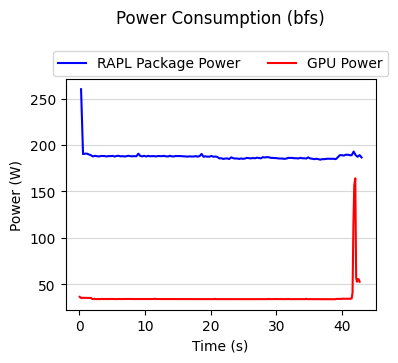

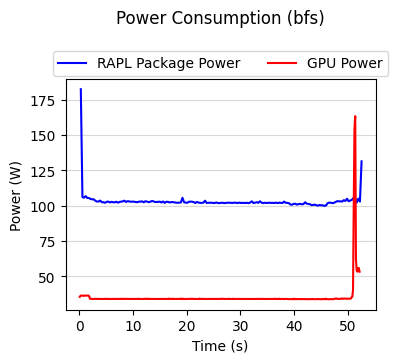

In [15]:
data_dir = "./altis_power_res/max_uncore/"

# altis_benchmarks_1
bfs_cpu = data_dir + "bfs_power_cpu.csv"
bfs_gpu = data_dir + "bfs_power_gpu.csv"
plot_power_CPU_GPU(bfs_cpu, bfs_gpu, "bfs")

data_dir = "./altis_power_res/min_uncore/"

# altis_benchmarks_1
bfs_cpu = data_dir + "bfs_power_cpu.csv"
bfs_gpu = data_dir + "bfs_power_gpu.csv"

plot_power_CPU_GPU(bfs_cpu, bfs_gpu, "bfs")

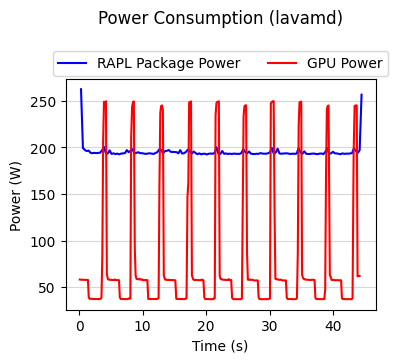

Total Energy Consumption: 11899.41 Joules


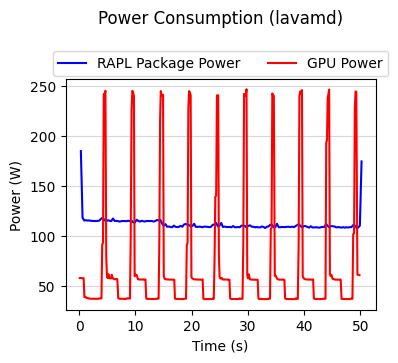

Total Energy Consumption: 8998.61 Joules


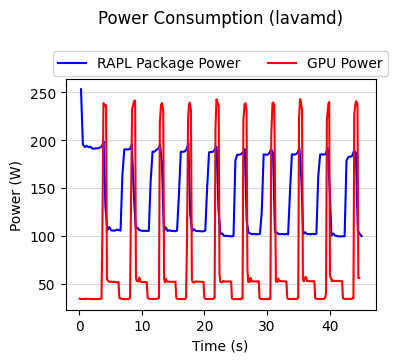

Total Energy Consumption: 9518.42 Joules


In [22]:
data_dir = "./altis_power_res/max_uncore/"

# altis_benchmarks_1
lavamd_cpu = data_dir + "lavamd_power_cpu.csv"
lavamd_gpu = data_dir + "lavamd_power_gpu.csv"
plot_power_CPU_GPU(lavamd_cpu, lavamd_gpu, "lavamd")
calculate_energy(lavamd_cpu,lavamd_gpu)

data_dir = "./altis_power_res/min_uncore/"

# altis_benchmarks_1
lavamd_cpu = data_dir + "lavamd_power_cpu.csv"
lavamd_gpu = data_dir + "lavamd_power_gpu.csv"
plot_power_CPU_GPU(lavamd_cpu, lavamd_gpu, "lavamd")
calculate_energy(lavamd_cpu,lavamd_gpu)

data_dir = "./altis_power_res/"

# altis_benchmarks_1
lavamd_cpu = data_dir + "lavamd_power_cpu.csv"
lavamd_gpu = data_dir + "lavamd_power_gpu.csv"
plot_power_CPU_GPU(lavamd_cpu, lavamd_gpu, "lavamd")
calculate_energy(lavamd_cpu,lavamd_gpu)